## Description:
这里使用掉包的方式和亲自造轮子的方式进行kaggle上的criteo数据集的实战， 关于这个数据集的下载和介绍， 可以见GBDT+LR的那一节

## 数据导入与简单处理

In [11]:
# 导入包
import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
import tensorflow.keras.backend as K
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.model_selection import train_test_split

In [12]:
# dense特征取对数， sparse特征类别编码
def process_feat(data, sparse_feats):
    df = data.copy()

    # sparse
    df_sparse = df[sparse_feats].fillna('-1')
    label_encoders = {}
    for feat in sparse_feats:
        label_encoder = LabelEncoder()
        df_sparse[feat] = label_encoder.fit_transform(df_sparse[feat])
        label_encoders[feat] = label_encoder

    df_new = pd.concat([df[dense_feats], df_sparse], axis=1)

    feature_columns = [
        {
            "feature_name": feat,
            "dim": int(df_new[feat].max()) + 1
        } for feat in dense_feats + sparse_feats
    ]
    return df_new, feature_columns, label_encoders

In [45]:
# 读入数据
path = '../../../Dataset/criteo_attribution_dataset/'

data = pd.read_csv(
    # path + 'demo.csv',
    path + 'criteo_attribution_dataset.tsv',
    # dtype=str,
    sep='\t',
    index_col=False,
    nrows=500000,   # out of 16468028

    # names=cols,
    # header=0,
)
data['label'] = data["click"]
cols = data.columns.values
print(cols)

['timestamp' 'uid' 'campaign' 'conversion' 'conversion_timestamp'
 'conversion_id' 'attribution' 'click' 'click_pos' 'click_nb' 'cost' 'cpo'
 'time_since_last_click' 'cat1' 'cat2' 'cat3' 'cat4' 'cat5' 'cat6' 'cat7'
 'cat8' 'cat9' 'label']


In [46]:
# data = data.get_chunk(100000)
# 去掉id列， 把测试集和训练集合并， 填充缺失值
# data.drop(['Id'], axis=1, inplace=True)
cols = data.columns.values
# print(f"{cols=}")

# dense 特征开头是I, sparse特征开头是C， label是标签

dense_feats = []
sparse_feats = ["uid", "campaign"] + ["cat" + str(i) for i in range(1, 10)]

# 数据预处理
feats, fcs, label_encoders = process_feat(data, sparse_feats)

In [47]:
print(fcs)

[{'feature_name': 'uid', 'dim': 403100}, {'feature_name': 'campaign', 'dim': 662}, {'feature_name': 'cat1', 'dim': 9}, {'feature_name': 'cat2', 'dim': 61}, {'feature_name': 'cat3', 'dim': 1653}, {'feature_name': 'cat4', 'dim': 20}, {'feature_name': 'cat5', 'dim': 50}, {'feature_name': 'cat6', 'dim': 30}, {'feature_name': 'cat7', 'dim': 15519}, {'feature_name': 'cat8', 'dim': 11}, {'feature_name': 'cat9', 'dim': 30}]


In [48]:
from tensorflow.keras.regularizers import l2

class FM_Layer(Layer):
    def __init__(self, feature_columns, k, w_reg=1e-6, v_reg=1e-6):
        """
        Factorization Machines
        :param feature_columns: A list. sparse column feature information.
        :param k: the latent vector
        :param w_reg: the regularization coefficient of parameter w
        :param v_reg: the regularization coefficient of parameter v
        """
        super(FM_Layer, self).__init__()
        self.sparse_feature_columns = feature_columns
        self.index_mapping = []
        self.feature_length = 0
        for feat in self.sparse_feature_columns:
            self.index_mapping.append(self.feature_length)
            self.feature_length += feat['dim']
        self.k = k
        self.w_reg = w_reg
        self.v_reg = v_reg

    def build(self, input_shape):
        self.w0 = self.add_weight(name='w0', shape=(1,),
                                  initializer=tf.zeros_initializer(),
                                  trainable=True)
        self.w = self.add_weight(name='w', shape=(self.feature_length, 1),
                                 initializer=tf.random_normal_initializer(),
                                 regularizer=l2(self.w_reg),
                                 trainable=True)
        self.V = self.add_weight(name='V', shape=(self.feature_length, self.k),
                                 initializer=tf.random_normal_initializer(),
                                 regularizer=l2(self.v_reg),
                                 trainable=True)

    def call(self, inputs, **kwargs):
        # mapping
        inputs = inputs + tf.cast(tf.convert_to_tensor(self.index_mapping), tf.dtypes.int64)
        # first order
        first_order = self.w0 + tf.reduce_sum(tf.nn.embedding_lookup(self.w, inputs), axis=1)  # (batch_size, 1)
        # second order
        second_inputs = tf.nn.embedding_lookup(self.V, inputs)  # (batch_size, fields, embed_dim)
        square_sum = tf.square(tf.reduce_sum(second_inputs, axis=1, keepdims=True))  # (batch_size, 1, embed_dim)
        sum_square = tf.reduce_sum(tf.square(second_inputs), axis=1, keepdims=True)  # (batch_size, 1, embed_dim)
        second_order = 0.5 * tf.reduce_sum(square_sum - sum_square, axis=2)  # (batch_size, 1)
        # outputs
        outputs = first_order + second_order
        return outputs


class FM(Model):
    def __init__(self, feature_columns, k, w_reg=1e-6, v_reg=1e-6):
        """
        Factorization Machines
        :param feature_columns: A list. sparse column feature information.
        :param k: the latent vector
        :param w_reg: the regularization coefficient of parameter w
		:param v_reg: the regularization coefficient of parameter v
        """
        super(FM, self).__init__()
        self.sparse_feature_columns = feature_columns
        self.fm = FM_Layer(feature_columns, k, w_reg, v_reg)

    def call(self, inputs, **kwargs):
        # inputs = tf.cast(inputs, tf.dtypes.int32)
        fm_outputs = self.fm(inputs)
        outputs = tf.nn.sigmoid(fm_outputs)
        return outputs

    def summary(self, **kwargs):
        sparse_inputs = Input(shape=(len(self.sparse_feature_columns),), dtype=tf.int32)
        Model(inputs=sparse_inputs, outputs=self.call(sparse_inputs)).summary()
    
    @property
    def cross_layer(self):
        return self.fm
        

In [49]:
# 划分训练和验证数据
x_trn, x_tst, y_trn, y_tst = train_test_split(feats, data['label'], test_size=0.1, random_state=2020)

In [50]:
# 定义模型
model = FM(fcs, k=16)
model.compile(
    optimizer=optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=['binary_accuracy'],
)

In [51]:
from tensorflow import keras

class DrawEmdingIn3D(keras.callbacks.Callback):
    def __init__(self):
        super(DrawEmdingIn3D, self).__init__()
        self._embedding_snapshots = np.array([[0, 0, 0, 0, 0, 0]])
        self._colors = []
        self._counter = 0

    def on_epoch_end(self, batch, logs=None):
        cur_vec = np.reshape(model.cross_layer.get_weights()[0][1,:], (1, 3))
        # print(f"{cur_vec.shape=}")
        plot_vec = np.concatenate((np.array([[0, 0, 0]]), cur_vec), axis=1)
        # print(f"{plot_vec.shape=}")
        self._embedding_snapshots = np.concatenate(
            (
                self._embedding_snapshots,
                plot_vec
            )
        )
        self._colors.append(self._counter)
        self._counter += 1



import datetime
log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [52]:
# draw_embedding_3d = DrawEmdingIn3D()

model.fit(x_trn, y_trn, epochs=10, batch_size=256, validation_data=(x_tst, y_tst), callbacks=[tensorboard_callback])

Epoch 1/10
1758/1758 [==============================] - 84s 48ms/step - loss: 0.6047 - binary_accuracy: 0.6832 - val_loss: 0.5959 - val_binary_accuracy: 0.6893
Epoch 2/10
1758/1758 [==============================] - 84s 48ms/step - loss: 0.5380 - binary_accuracy: 0.7412 - val_loss: 0.6088 - val_binary_accuracy: 0.6847
Epoch 3/10
1758/1758 [==============================] - 84s 48ms/step - loss: 0.4118 - binary_accuracy: 0.8496 - val_loss: 0.6528 - val_binary_accuracy: 0.6697
Epoch 4/10
1758/1758 [==============================] - 83s 47ms/step - loss: 0.2716 - binary_accuracy: 0.9317 - val_loss: 0.7064 - val_binary_accuracy: 0.6681
Epoch 5/10
1758/1758 [==============================] - 83s 47ms/step - loss: 0.1917 - binary_accuracy: 0.9527 - val_loss: 0.7573 - val_binary_accuracy: 0.6636
Epoch 6/10
1758/1758 [==============================] - 83s 47ms/step - loss: 0.1600 - binary_accuracy: 0.9592 - val_loss: 0.7915 - val_binary_accuracy: 0.6648
Epoch 7/10
1758/1758 [==================

In [53]:
# 预测
y_pred = model.predict(x_tst)

In [60]:
model.cross_layer.get_weights()[2].shape

(421145, 16)

In [57]:
label_encoders

{'uid': LabelEncoder(),
 'campaign': LabelEncoder(),
 'cat1': LabelEncoder(),
 'cat2': LabelEncoder(),
 'cat3': LabelEncoder(),
 'cat4': LabelEncoder(),
 'cat5': LabelEncoder(),
 'cat6': LabelEncoder(),
 'cat7': LabelEncoder(),
 'cat8': LabelEncoder(),
 'cat9': LabelEncoder()}

In [16]:
def get_embedding_name_and_vec(feat_name):
    fids = data[feat_name].unique().tolist()
    start_idx = 0
    end_idx = 0
    for info in fcs:
        if info["feature_name"] != feat_name:
            start_idx += info["dim"]
        else:
            end_idx = start_idx + info["dim"]
            break
    else:
        raise ValueError("didn't find the feature")
    embs_wrong_order = model.cross_layer.get_weights()[2][start_idx:end_idx]
    return fids, embs_wrong_order[feats[feat_name].unique()], embs_wrong_order

In [61]:
def get_embedding_name_and_vec(label, emd_col, data: pd.DataFrame):
    data_ = data[emd_col].dropna()
    start_idx = 0
    end_idx = 0
    for info in fcs:
        if info["feature_name"] != emd_col:
            start_idx += info["dim"]
        else:
            end_idx = start_idx + info["dim"]
            break
    else:
        raise ValueError("didn't find the feature")
    embs_wrong_order = model.cross_layer.get_weights()[2][start_idx:end_idx]
    label_encoder = label_encoders[emd_col]
    idxes = label_encoder.transform(data_.unique()).tolist()
    return [label] * len(idxes), embs_wrong_order[idxes], embs_wrong_order

In [71]:
# sub_data = data[np.logical_and(data["label"] == 1, data["campaign"] == 22589171)] # 109
# sub_data = data[np.logical_and(data["label"] == 1, data["campaign"] == 884761)] # 218
# sub_data = data[np.logical_and(data["label"] == 1, data["campaign"] == 18975823)] # 2187
sub_data = data[np.logical_and(data["label"] == 1, data["campaign"] == 17686799)] # 3406
print(sub_data.shape)

(3406, 23)


In [76]:
sub_data = data[np.logical_and(data["label"] == 1, data["campaign"] == 18975823)]
print(sub_data.shape)
interested_fids_1, embs_1, _ = get_embedding_name_and_vec("ad1", "uid", sub_data)

(2187, 23)


In [77]:
sub_data = data[np.logical_and(data["label"] == 1, data["campaign"] == 17686799)]
print(sub_data.shape)
interested_fids_2, embs_2, _ = get_embedding_name_and_vec("ad2", "uid", sub_data)

(3406, 23)


In [78]:
interested_fids = interested_fids_1 + interested_fids_2
embs = np.concatenate((embs_1, embs_2), axis=0)
print(embs.shape)

(4874, 16)


In [186]:
model.cross_layer.get_weights()[0][4, :]

array([ 0.15629388, -0.11785229,  0.04347787,  0.42729002,  0.2979995 ,
        0.976469  , -0.17661291, -0.00541568,  0.5376856 ,  0.16127972,
       -0.57626116, -0.0517107 , -0.24026956,  0.42488104,  0.25337875,
        0.11354011], dtype=float32)

In [79]:
# Set up a logs directory, so Tensorboard knows where to look for files.
import os

log_dir='./logs/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)


# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for interested_fid in interested_fids:
    f.write("{}\n".format(interested_fid))
weights = tf.Variable(embs)

from tensorboard.plugins import projector
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))
# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

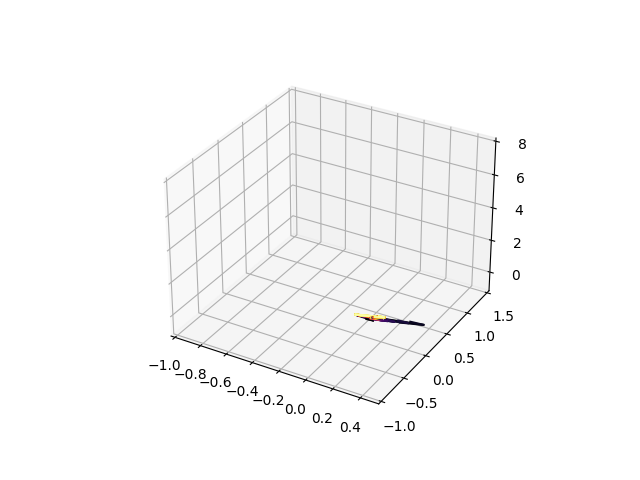

In [11]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import Normalize

# soa = np.array([[0, 0, 0, 1, -2, 0]])
# colors = [0, 100]
soa = draw_embedding_3d._embedding_snapshots
colors = draw_embedding_3d._colors


norm = Normalize()
norm.autoscale(colors)

colormap = cm.inferno

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color=colormap(norm(colors)))
ax.set_xlim([-1, 0.5])
ax.set_ylim([-1, 1.5])
ax.set_zlim([-1, 8])
plt.show()